<a href="https://colab.research.google.com/github/brunobro/integrating-MSD-AHP-for-the-selection-of-abiotic-stress-tolerant-corn-hybrids/blob/main/SelectionOfAbiotic_Stress_TolerantCornHybrids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Integrating Multidimensional Scaling and Automated AHP for the Selection of Abiotic-Stress-Tolerant Corn Hybrids**

**Abstract:**
This script implements a decision support system (DSS) for ranking and selecting
corn (Zea mays L.) hybrids with higher tolerance to multiple abiotic stresses
(drought, salinity, and aluminum toxicity). The methodology combines
Multidimensional Scaling (MDS) and the Automated Analytic Hierarchy Process (AAHP)
to provide a single, objective tolerance score for each hybrid.

**Authors:**
Fábio Steiner1,2,* , Bruno Rodrigues de Oliveira3,* , Marco Aparecido Queiroz Duarte1 , Sthela Silva Melo1 , Ruth Teles Barbosa2  , Alan Mario Zuffo4 , Jorge González Aguilera1 , Fabio Ribeiro Barros4

1 State University of Mato Grosso do Sul (UEMS), Cassilândia, MS, Brazil.

2 State University of Mato Grosso do Sul (UEMS), Aquidauana, MS, Brazil.

3 Pantanal Editora, Nova Xavantina, MT, Brazil.

4 State University of Maranhão (UEMA), Balsas, MA, Brazil.

*Correspondence: steiner@uems.br; bruno@editorapantanal.com.br




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Upload required
from AHPTD import AHPTD

# Read and show data

In [22]:
'''
Read data and Create dataset
'''
df = pd.read_excel('data.xlsx')
display(df)

numeric_cols = ['E', 'PH', 'TPL', 'LA', 'LR', 'TRL', 'RV', 'RS', 'SDM', 'RDM', 'TDM']

,Hybrid,Treatment,Repetition,E,PH,TPL,LA,LR,TRL,RV,RS,SDM,RDM,TDM
0,AG 8088 PRO2,Control,1,68,14.0,37.0,17.300,23.0,58.400,12.836320,0.920152,26.3,24.2,50.5
1,AG 8088 PRO2,Control,2,68,16.0,37.0,16.800,21.0,60.900,13.385820,0.858131,28.9,24.8,53.7
2,AG 8088 PRO2,Control,3,70,18.0,41.0,18.900,23.0,62.800,13.803440,0.836923,32.5,27.2,59.7
3,AG 8088 PRO2,Control,4,70,19.0,39.5,20.200,20.5,64.100,14.089180,0.755747,34.8,26.3,61.1
4,AG 8088 PRO2,Control,5,78,20.0,43.0,21.100,23.0,66.000,14.506800,0.751381,36.2,27.2,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STINE 9075 VIP3,Al toxicity,2,76,19.0,40.0,30.816,21.0,54.432,17.091648,0.500949,52.7,26.4,79.1
356,STINE 9075 VIP3,Al toxicity,3,76,20.0,42.0,31.779,22.0,56.133,17.625762,0.513915,53.9,27.7,81.6
357,STINE 9075 VIP3,Al toxicity,4,82,23.0,48.0,32.421,25.0,57.267,17.981838,0.514545,55.0,28.3,83.3
358,STINE 9075 VIP3,Al toxicity,5,86,25.0,47.0,33.384,22.0,58.968,18.515952,0.514493,55.2,28.4,83.6


## Coefficient of variation

In [23]:
# Calculate the coefficient of variation for each numeric column
cv = df[numeric_cols].std() / df[numeric_cols].mean() * 100

# Print the coefficient of variation
print("Coefficient of Variation:")
display(cv)

Coefficient of Variation:


,0
E,20.686996
PH,32.903543
TPL,29.804096
LA,53.452132
LR,31.401149
TRL,38.222123
RV,39.822178
RS,38.112893
SDM,45.529662
RDM,37.626497


# Calculates the mean of the Repetition

In [24]:
# Mean dataframe for repetition
df_mean_all = df.groupby(['Hybrid', 'Treatment']).mean(numeric_only=True).reset_index()
df_mean_all = df_mean_all.drop('Repetition', axis=1)  # Remove 'Repetition' column directly
display(df_mean_all)

,Hybrid,Treatment,E,PH,TPL,LA,LR,TRL,RV,RS,SDM,RDM,TDM
0,AG 8088 PRO2,Al toxicity,63.666667,15.000000,29.500000,10.920000,14.500000,39.200000,16.001440,1.277083,12.266667,15.666667,27.933333
1,AG 8088 PRO2,Control,72.000000,18.416667,41.000000,19.283333,22.583333,63.450000,13.946310,0.809251,33.383333,26.700000,60.083333
2,AG 8088 PRO2,Drought,54.666667,10.916667,20.750000,7.400000,9.833333,35.300000,7.537256,1.330628,11.800000,15.666667,27.466667
3,AG 8088 PRO2,Salinity,52.000000,8.500000,16.416667,6.733333,7.916667,11.283333,2.125780,0.410225,8.316667,3.383333,11.700000
4,AG 8700 PRO4,Al toxicity,96.333333,27.500000,48.666667,29.800000,21.166667,70.800000,31.123680,0.657145,69.766667,45.850000,115.616667
5,AG 8700 PRO4,Control,97.000000,27.750000,58.500000,35.233333,30.750000,112.000000,29.892800,1.000497,68.533333,68.333333,136.866667
6,AG 8700 PRO4,Drought,90.000000,20.000000,41.583333,19.400000,21.583333,86.750000,23.153575,1.244650,48.366667,60.000000,108.366667
7,AG 8700 PRO4,Salinity,76.000000,15.916667,35.583333,18.216667,19.666667,64.483333,20.247767,1.124770,41.750000,46.666667,88.416667
8,AG 8701 PRO4,Al toxicity,100.000000,18.666667,48.166667,23.350000,29.500000,76.300000,40.728940,1.060693,43.733333,46.400000,90.133333
9,AG 8701 PRO4,Control,100.000000,18.500000,45.500000,23.833333,27.000000,127.800000,36.116280,1.470152,43.350000,63.333333,106.683333


# Apply MDS

As there are variables with high correlation, MDS is applied to reduce the mass of data to the linear combination of only two variables.

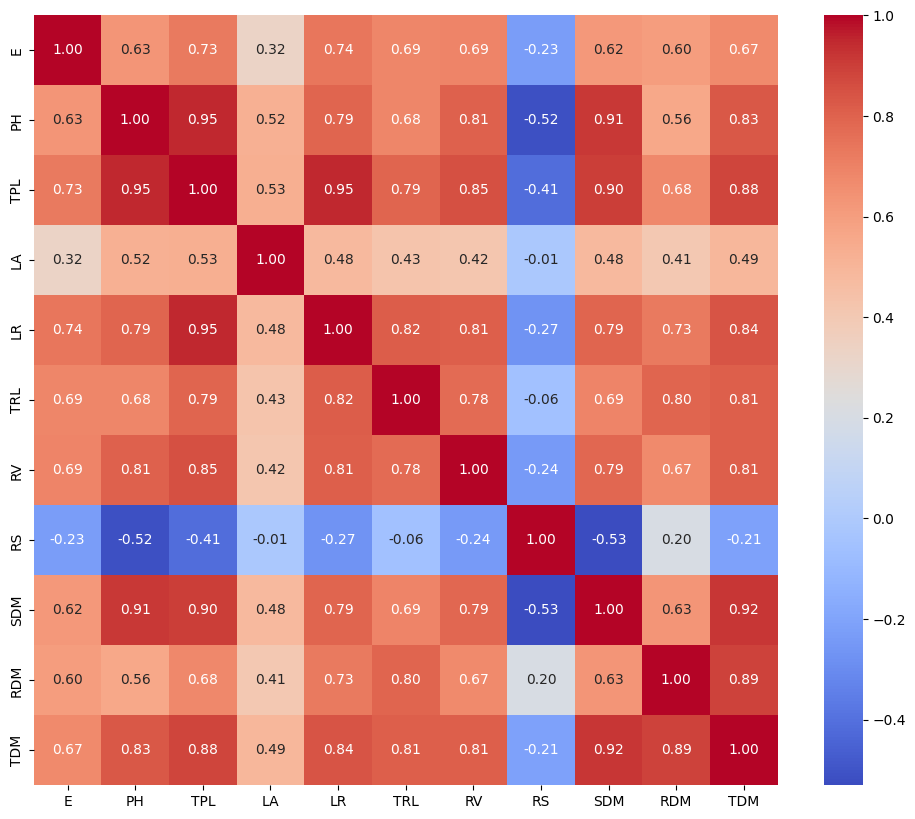

In [25]:
# Show correlation
plt.figure(figsize=(12, 10))
correlation_matrix = df_mean_all[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=False)
plt.show()

Stress for 2 dimension: 575.2349
Stress for 3 dimension: 187.3034
Stress for 4 dimension: 57.8109
Stress for 5 dimension: 30.9070
Stress for 6 dimension: 20.5406
Stress for 7 dimension: 14.1052
Stress for 8 dimension: 13.2009
Stress for 9 dimension: 8.9191
Stress for 10 dimension: 9.4872
Stress for 11 dimension: 8.4180


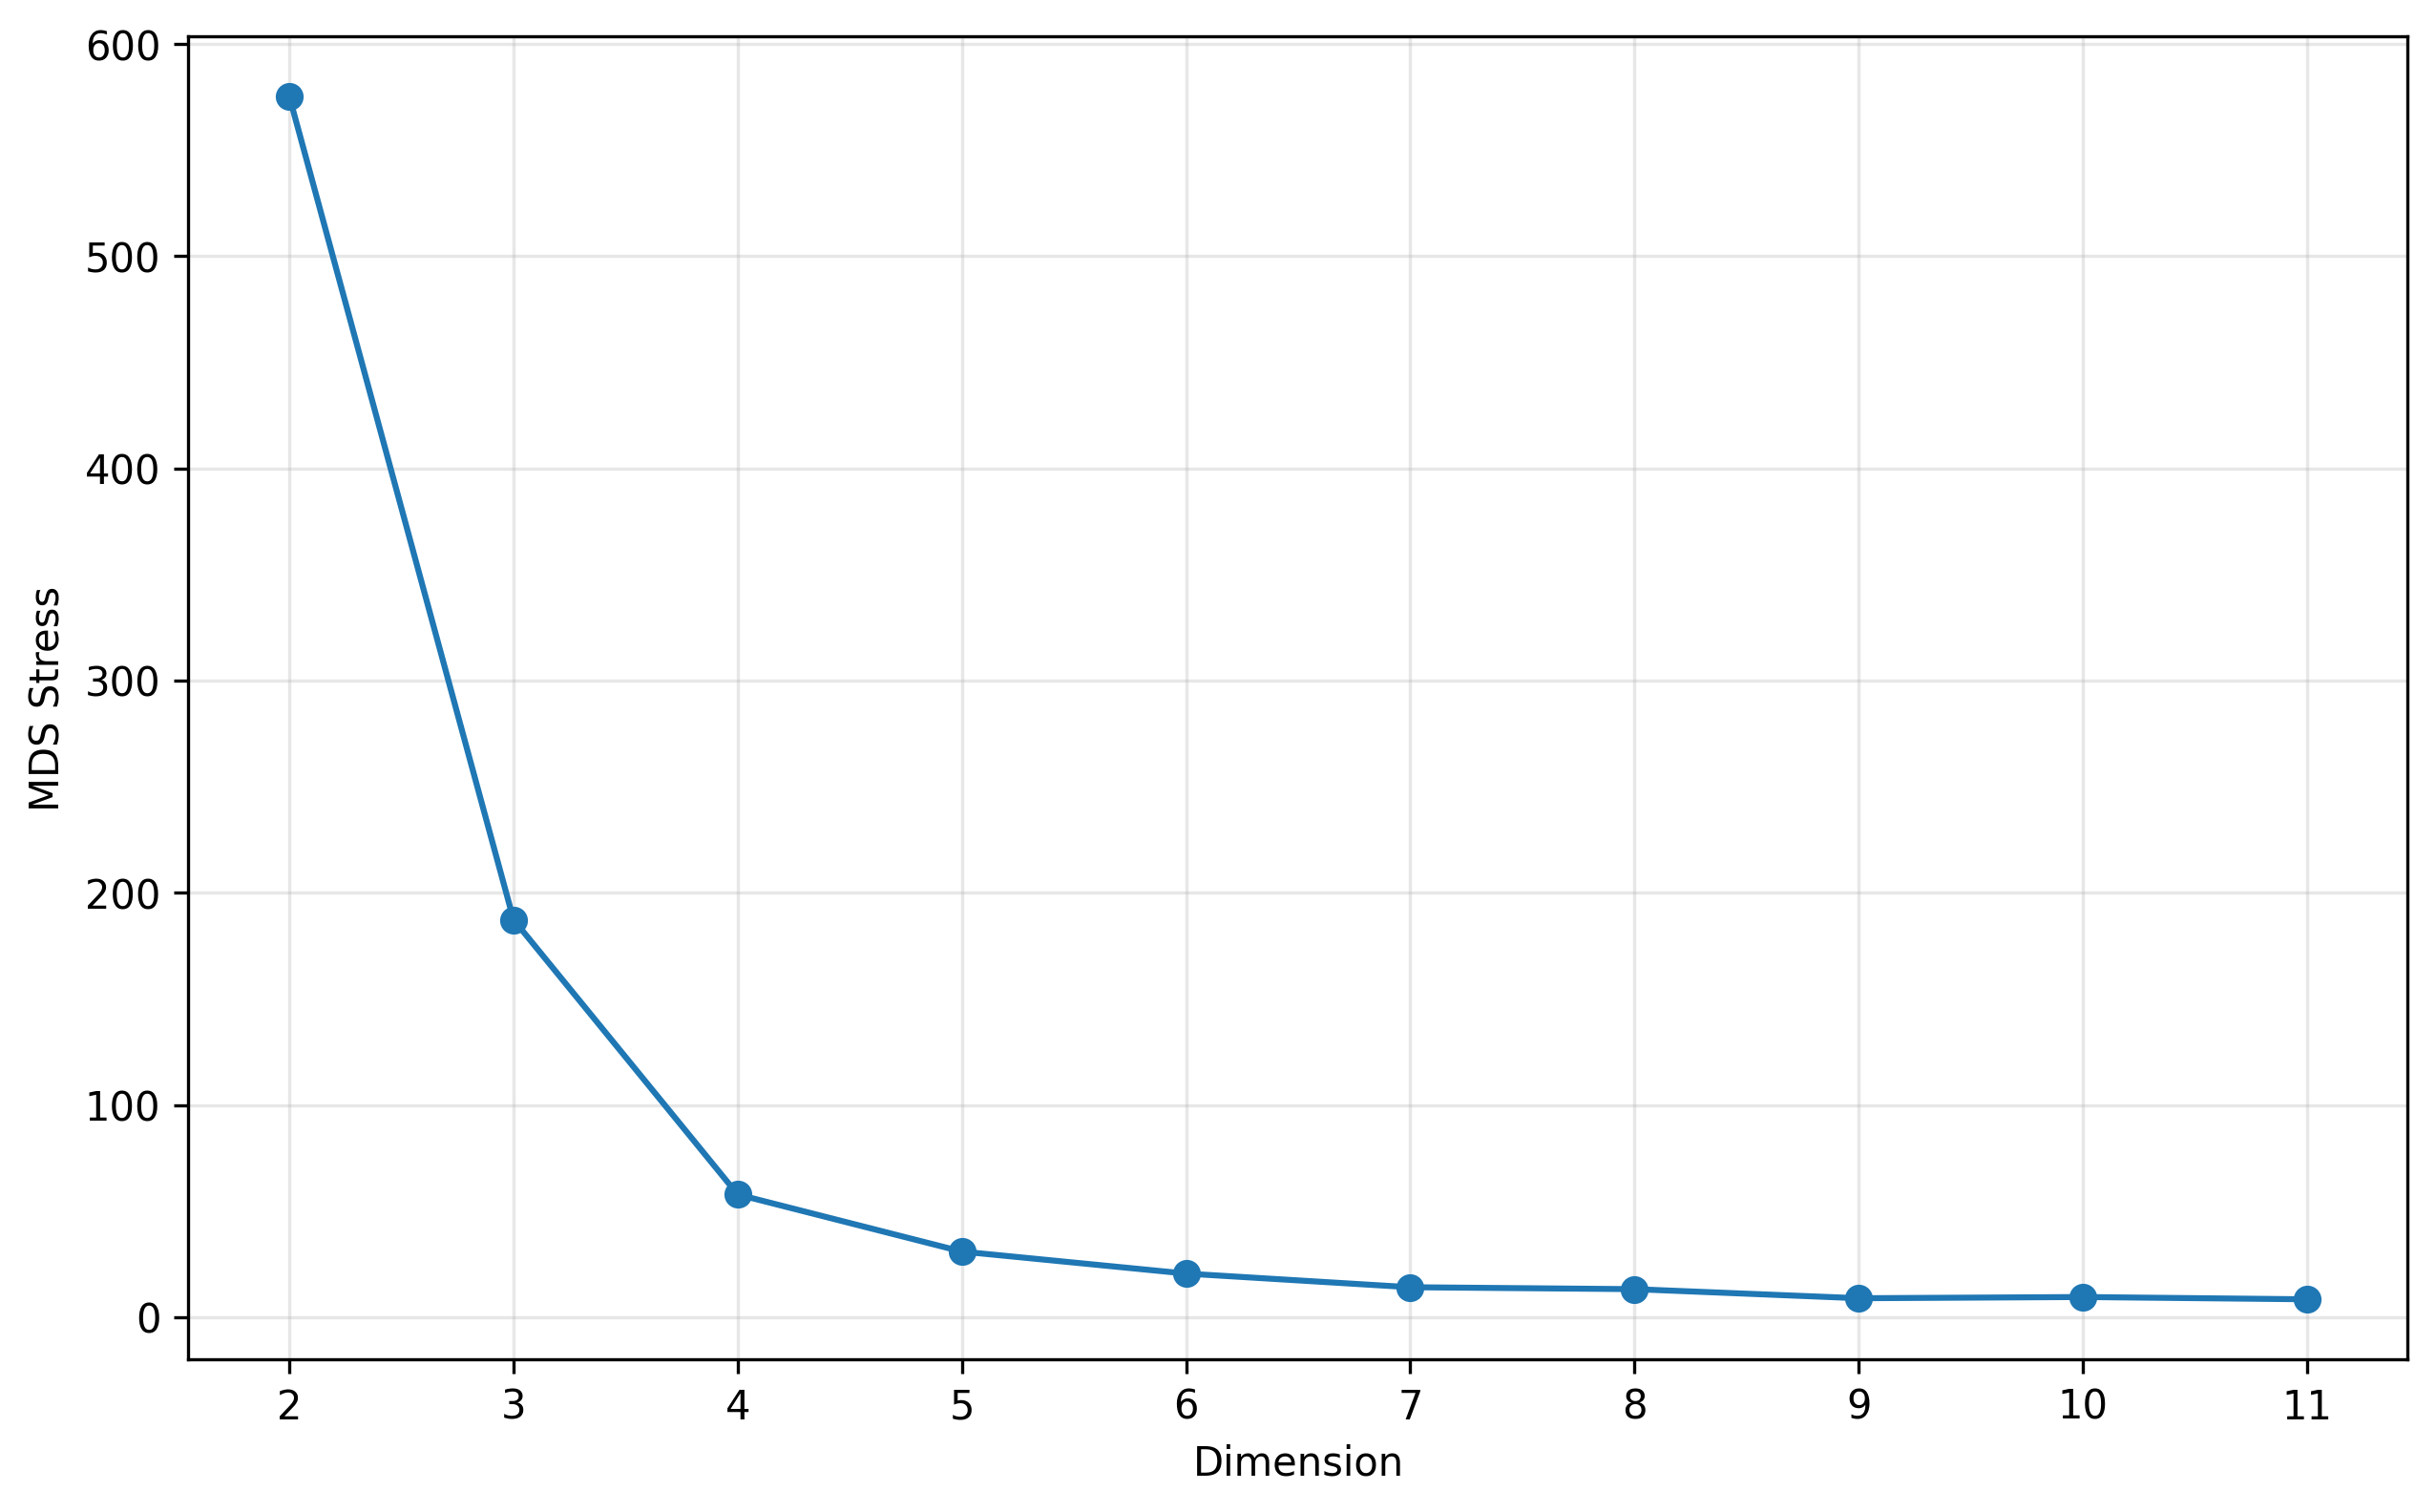


 Shift values ​​to apply to each dimension:
 MDS_Dim_1    3.353649
MDS_Dim_2    4.947558
MDS_Dim_3    2.186912
MDS_Dim_4    2.897620
MDS_Dim_5    2.088615
MDS_Dim_6    1.672512
dtype: float64

 Original difference in Dimension 1 between the first two samples: -0.4248

 Difference after shift in Dimension 1 between the first two samples: -0.4248

 MDS dataframe with non-negative components (scaled):



,Hybrid,Treatment,MDS_Dim_1,MDS_Dim_2,MDS_Dim_3,MDS_Dim_4,MDS_Dim_5,MDS_Dim_6
0,AG 8088 PRO2,Al toxicity,1.005770,7.762826,2.024630,4.225759,3.200361,1.544501
1,AG 8088 PRO2,Control,1.430595,5.590975,2.545743,3.655341,2.075418,1.036987
2,AG 8088 PRO2,Drought,1.472582,8.980278,2.373863,4.578175,4.168849,1.349179
3,AG 8088 PRO2,Salinity,0.000000,9.519021,3.792195,4.042945,4.767203,0.125136
4,AG 8700 PRO4,Al toxicity,3.642394,3.478215,2.615008,1.520114,1.232270,0.019152
5,AG 8700 PRO4,Control,4.403202,1.773286,1.836734,1.819267,0.287564,2.066690
6,AG 8700 PRO4,Drought,3.969875,4.231400,1.317461,2.874396,2.231738,1.427563
7,AG 8700 PRO4,Salinity,3.169370,5.496428,1.879499,3.655606,2.458312,1.251356
8,AG 8701 PRO4,Al toxicity,2.640748,3.649407,0.302797,2.230611,0.609860,1.256684
9,AG 8701 PRO4,Control,3.551066,3.034222,0.134204,1.935297,1.837046,2.765769


In [26]:
# Select the relevant numeric columns
data = df_mean_all[numeric_cols]

# Standardize the data (optional, but recommended for distance-based MDS)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Calculate the dissimilarity matrix (using Euclidean distance as an example)
dissimilarity_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Apply the MDS Metric to different numbers of dimensions
n_components_range = range(2, len(numeric_cols) + 1)
stress_values      = []
embeddings         = {}

for n_components in n_components_range:
    mds = MDS(n_components=n_components, metric=True, random_state=0, dissimilarity='precomputed', normalized_stress='auto')
    embedding = mds.fit_transform(dissimilarity_matrix)
    stress = mds.stress_
    stress_values.append(stress)
    embeddings[n_components] = embedding
    print(f"Stress for {n_components} dimension: {stress:.4f}")

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(n_components_range, stress_values, marker='o')
plt.xlabel('Dimension')
plt.ylabel('MDS Stress')
plt.xticks(n_components_range)
plt.grid(alpha=0.3)
plt.show()

n_components_selected = 6
embedding_selected = embeddings[n_components_selected]

# Create a dataframe with the resulting embedding
mds_df = pd.DataFrame(data=embedding_selected, columns=[f'MDS_Dim_{i+1}' for i in range(n_components_selected)])

# Add a constant so there are no negative values
# Find the maximum negative value in each column of the MDS dataframe
min_values = mds_df.min()
shift_values = np.abs(min_values.where(min_values < 0, 0)) # Apenas pega o valor absoluto dos negativos

print("\n Shift values ​​to apply to each dimension:\n", shift_values)

# Apply shift to each column
mds_shifted_df = mds_df.copy()
for col in mds_shifted_df.columns:
    mds_shifted_df[col] = mds_shifted_df[col] + shift_values[col]

# (Optional) Check whether differences between points are preserved in a dimension
if n_components >= 1:
    original_diff = mds_df['MDS_Dim_1'].iloc[0] - mds_df['MDS_Dim_1'].iloc[1]
    shifted_diff = mds_shifted_df['MDS_Dim_1'].iloc[0] - mds_shifted_df['MDS_Dim_1'].iloc[1]
    print(f"\n Original difference in Dimension 1 between the first two samples: {original_diff:.4f}")
    print(f"\n Difference after shift in Dimension 1 between the first two samples: {shifted_diff:.4f}")

# Concatenate with non-numeric columns for analysis (optional)
metadata = df_mean_all[['Hybrid', 'Treatment']]
mds_shifted_df = pd.concat([metadata.reset_index(drop=True), mds_shifted_df], axis=1)

print("\n MDS dataframe with non-negative components (scaled):\n")
display(mds_shifted_df)

# Transformed data: Calculates the distance of samples in the control relative to the stress treatments

In [27]:
# Calculates the weighted Manhattan distance
def w_dist(v1, v2):
    return np.sum(np.abs(v1.to_numpy() - v2.to_numpy()))

# Mean for repetition
#df_all_treatment = df.copy()
#df_all_treatment = mds_df.copy()
df_all_treatment = mds_shifted_df.copy()

df_all_treatment_control    = df_all_treatment[df_all_treatment['Treatment'] == 'Control']
df_all_treatment_drought    = df_all_treatment[df_all_treatment['Treatment'] == 'Drought']
df_all_treatment_salinity   = df_all_treatment[df_all_treatment['Treatment'] == 'Salinity']
df_all_treatment_toxicityAl = df_all_treatment[df_all_treatment['Treatment'] == 'Al toxicity']

del df_all_treatment_control['Treatment']
del df_all_treatment_drought['Treatment']
del df_all_treatment_salinity['Treatment']
del df_all_treatment_toxicityAl['Treatment']

distances_transformed = []
Hybrids = np.unique(df_all_treatment['Hybrid'])

for Hybrid in Hybrids:

    Hybrid_control    = df_all_treatment_control[df_all_treatment_control['Hybrid'] == Hybrid]
    Hybrid_drought    = df_all_treatment_drought[df_all_treatment_drought['Hybrid'] == Hybrid]
    Hybrid_salinity   = df_all_treatment_salinity[df_all_treatment_salinity['Hybrid'] == Hybrid]
    Hybrid_toxicityAl = df_all_treatment_toxicityAl[df_all_treatment_toxicityAl['Hybrid'] == Hybrid]

    del Hybrid_control['Hybrid']
    del Hybrid_drought['Hybrid']
    del Hybrid_salinity['Hybrid']
    del Hybrid_toxicityAl['Hybrid']

    d1 = w_dist(Hybrid_drought, Hybrid_control)
    d2 = w_dist(Hybrid_salinity, Hybrid_control)
    d3 = w_dist(Hybrid_toxicityAl, Hybrid_control)

    distances_transformed.append([d1, d2, d3])

# Convert to array
distances_transformed = np.array(distances_transformed)

# Dataframe for distances
df_distances_transformed = pd.DataFrame(distances_transformed, columns=['Drought', 'Salinity', 'Al toxicity'])
df_distances_transformed['Hybrid'] = Hybrids
display(df_distances_transformed)

,Drought,Salinity,Al toxicity,Hybrid
0,6.931627,10.596333,5.320662,AG 8088 PRO2
1,7.049143,9.822160,6.535406,AG 8700 PRO4
2,4.696082,6.492580,4.725680,AG 8701 PRO4
3,2.439638,11.587822,8.868394,AS 1868 PRO4
4,7.092629,9.490029,3.492208,B 2800 VYHR
5,2.864558,9.570592,8.874711,BP 2201 VIP3
6,4.970960,12.637755,8.643470,DKB 360 PRO3
7,4.772766,7.201765,5.061762,DKB 390 PRO4
8,7.734655,8.385102,5.768920,FS 575 PWU
9,7.741874,5.303740,5.928850,GALO VIP3


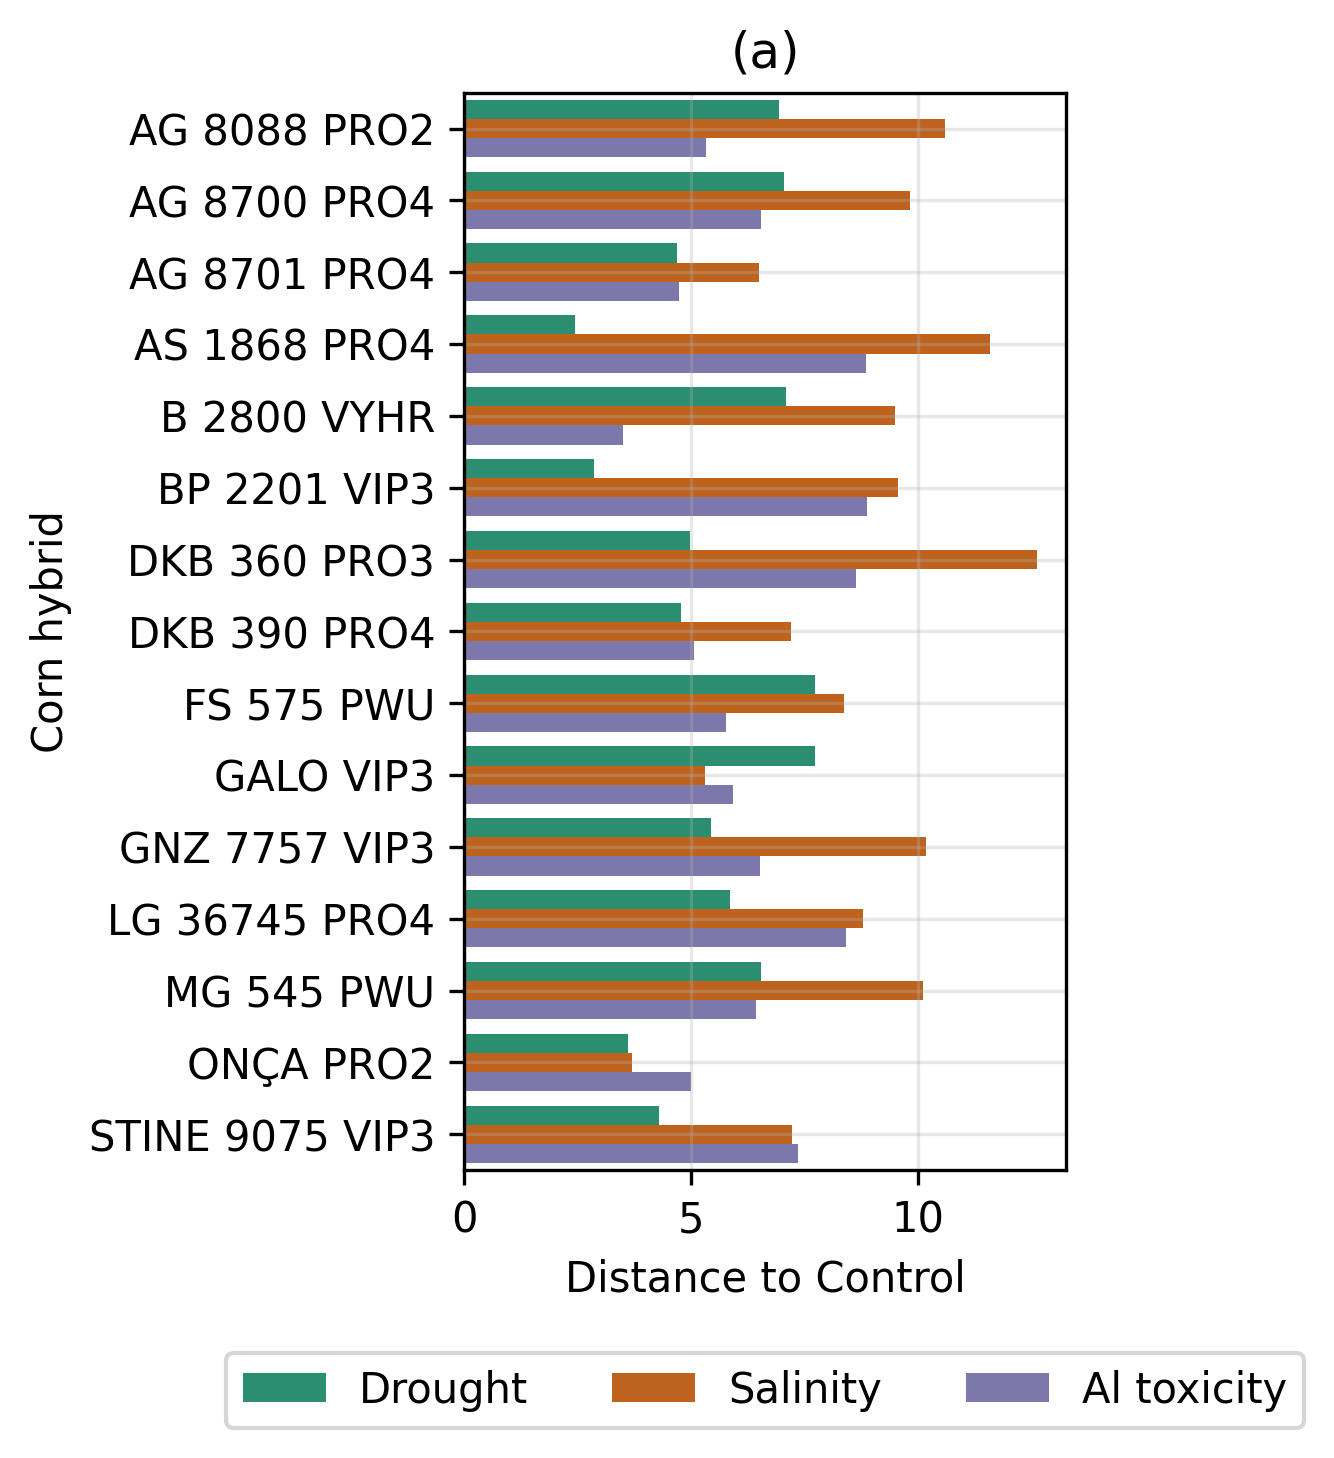

In [28]:
# Create a grouped bar plot
plt.figure(figsize=(4, 5), dpi=300)

df_distances_melt_transformed = pd.melt(df_distances_transformed, id_vars=['Hybrid'], value_vars=['Drought', 'Salinity', 'Al toxicity'], var_name='Treatment', value_name='Distance')

sns.barplot(y='Hybrid', x='Distance', hue='Treatment', data=df_distances_melt_transformed, orient='h', palette='Dark2')
plt.grid(alpha=0.3)
plt.title('(a)')
plt.ylabel("Corn hybrid")
plt.xlabel("Distance to Control")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()
plt.show()


# Original data: Calculates the distance of samples in the control relative to the stress treatments

In [29]:
# Mean for repetition
df_all_treatment = df_mean_all.copy()

df_all_treatment_control    = df_all_treatment[df_all_treatment['Treatment'] == 'Control']
df_all_treatment_drought    = df_all_treatment[df_all_treatment['Treatment'] == 'Drought']
df_all_treatment_salinity   = df_all_treatment[df_all_treatment['Treatment'] == 'Salinity']
df_all_treatment_toxicityAl = df_all_treatment[df_all_treatment['Treatment'] == 'Al toxicity']

del df_all_treatment_control['Treatment']
del df_all_treatment_drought['Treatment']
del df_all_treatment_salinity['Treatment']
del df_all_treatment_toxicityAl['Treatment']

distances_original = []

for Hybrid in Hybrids:

    Hybrid_control    = df_all_treatment_control[df_all_treatment_control['Hybrid'] == Hybrid]
    Hybrid_drought    = df_all_treatment_drought[df_all_treatment_drought['Hybrid'] == Hybrid]
    Hybrid_salinity   = df_all_treatment_salinity[df_all_treatment_salinity['Hybrid'] == Hybrid]
    Hybrid_toxicityAl = df_all_treatment_toxicityAl[df_all_treatment_toxicityAl['Hybrid'] == Hybrid]

    del Hybrid_control['Hybrid']
    del Hybrid_drought['Hybrid']
    del Hybrid_salinity['Hybrid']
    del Hybrid_toxicityAl['Hybrid']

    d1 = w_dist(Hybrid_drought, Hybrid_control)
    d2 = w_dist(Hybrid_salinity, Hybrid_control)
    d3 = w_dist(Hybrid_toxicityAl, Hybrid_control)

    distances_original.append([d1, d2, d3])

# Convert to array
distances = np.array(distances_original)

# Dataframe for distances
df_distances_original = pd.DataFrame(distances_original, columns=['Drought', 'Salinity', 'Al toxicity'])
df_distances_original['Hybrid'] = Hybrids
display(df_distances_original)

,Drought,Salinity,Al toxicity,Hybrid
0,170.030431,242.869556,130.769629,AG 8088 PRO2
1,145.900045,238.035974,113.507565,AG 8700 PRO4
2,77.831318,95.711538,96.205453,AG 8701 PRO4
3,44.030342,331.379467,222.166884,AS 1868 PRO4
4,105.852544,131.162486,62.147306,B 2800 VYHR
5,39.709839,193.133141,165.315184,BP 2201 VIP3
6,96.435787,269.192433,140.376536,DKB 360 PRO3
7,132.291905,126.535475,95.585288,DKB 390 PRO4
8,191.141913,190.115848,143.278599,FS 575 PWU
9,116.490564,142.137605,132.052376,GALO VIP3


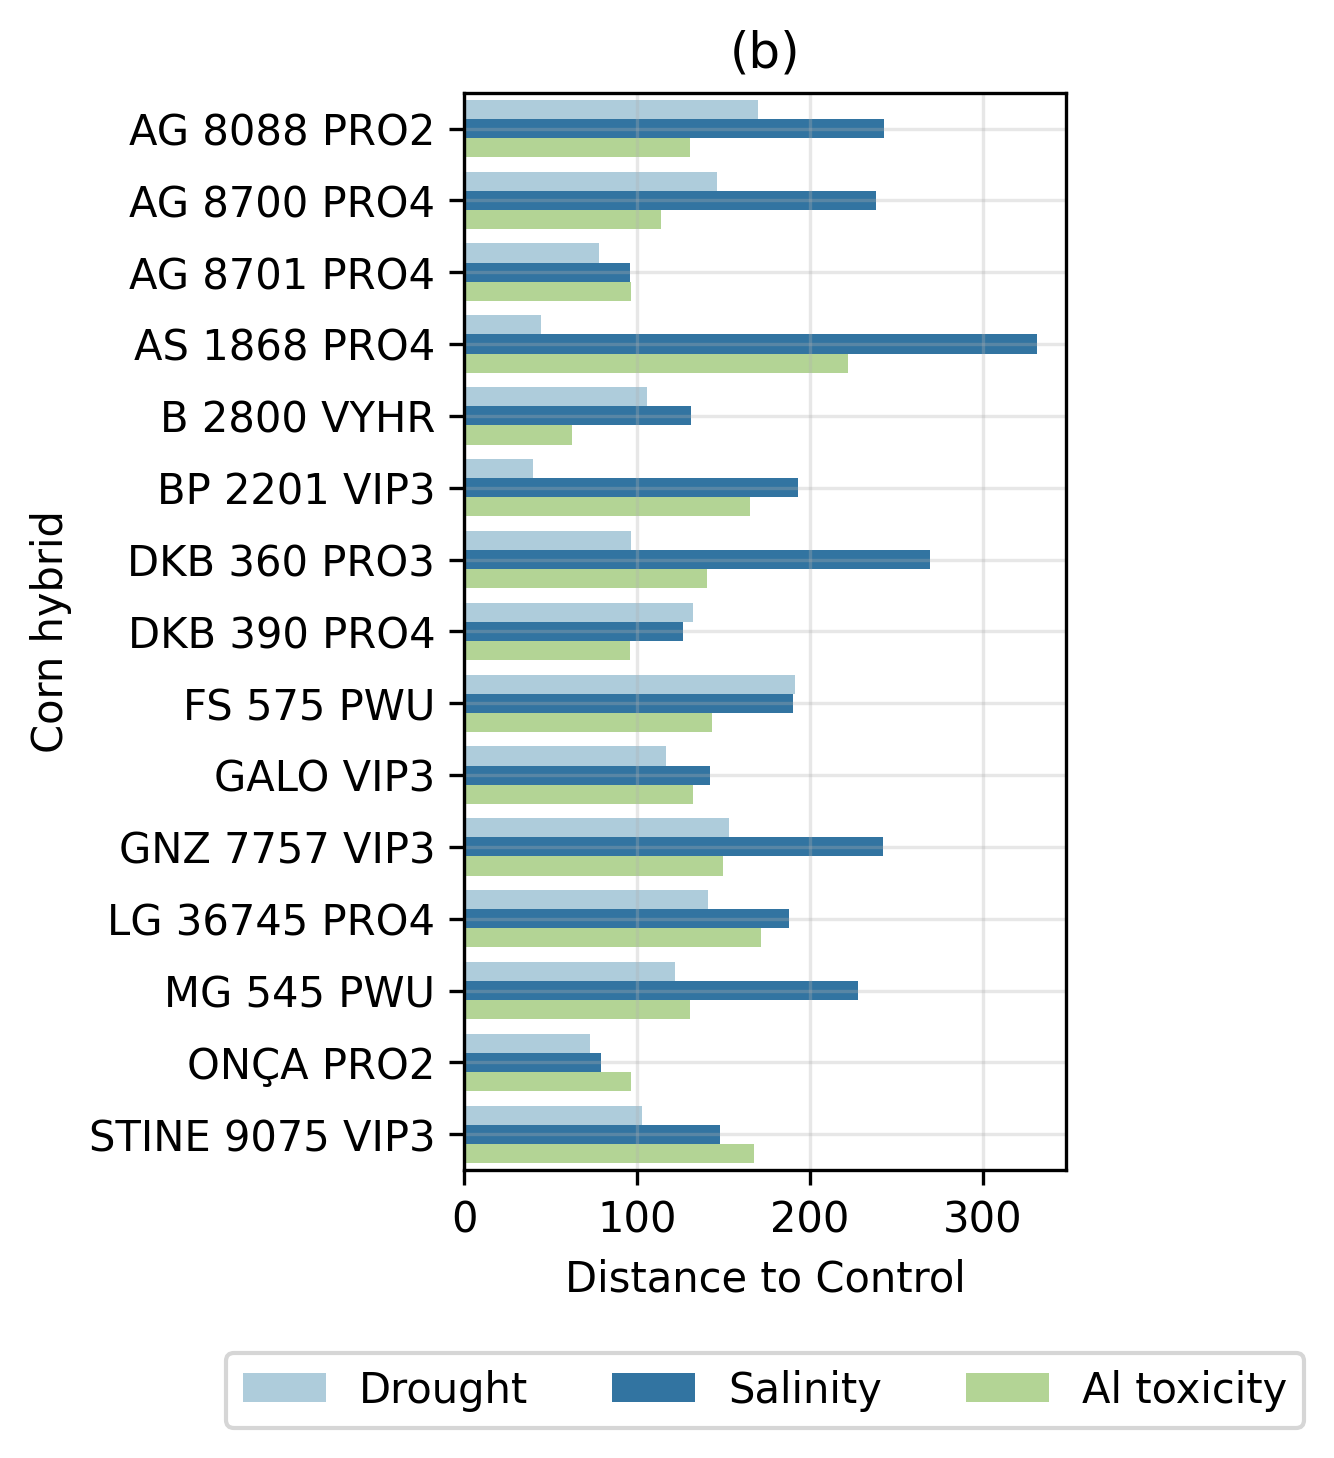

In [30]:
# Create a grouped bar plot
plt.figure(figsize=(4, 5), dpi=300)

df_distances_melt_original = pd.melt(df_distances_original, id_vars=['Hybrid'], value_vars=['Drought', 'Salinity', 'Al toxicity'], var_name='Treatment', value_name='Distance')

sns.barplot(y='Hybrid', x='Distance', hue='Treatment', data=df_distances_melt_original, orient='h', palette='Paired')
plt.grid(alpha=0.3)
plt.title('(b)')
plt.ylabel("Corn hybrid")
plt.xlabel("Distance to Control")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()
plt.show()


# Data transformed: Hybrid selection using AHPTD for each repetition

## Same criteria weights

CR of Goal:  0.04622549644738945
Vector of Criteria:  [0.49338597 0.31081368 0.19580035]
CR of Criteria - Control/Drought:  0.035520732530588406
CR of Criteria - Control/Salinity:  0.038459097827312376
CR of Criteria - Control/Al toxicity:  0.04093007206083864

Better Hybrid:  ONÇA PRO2 



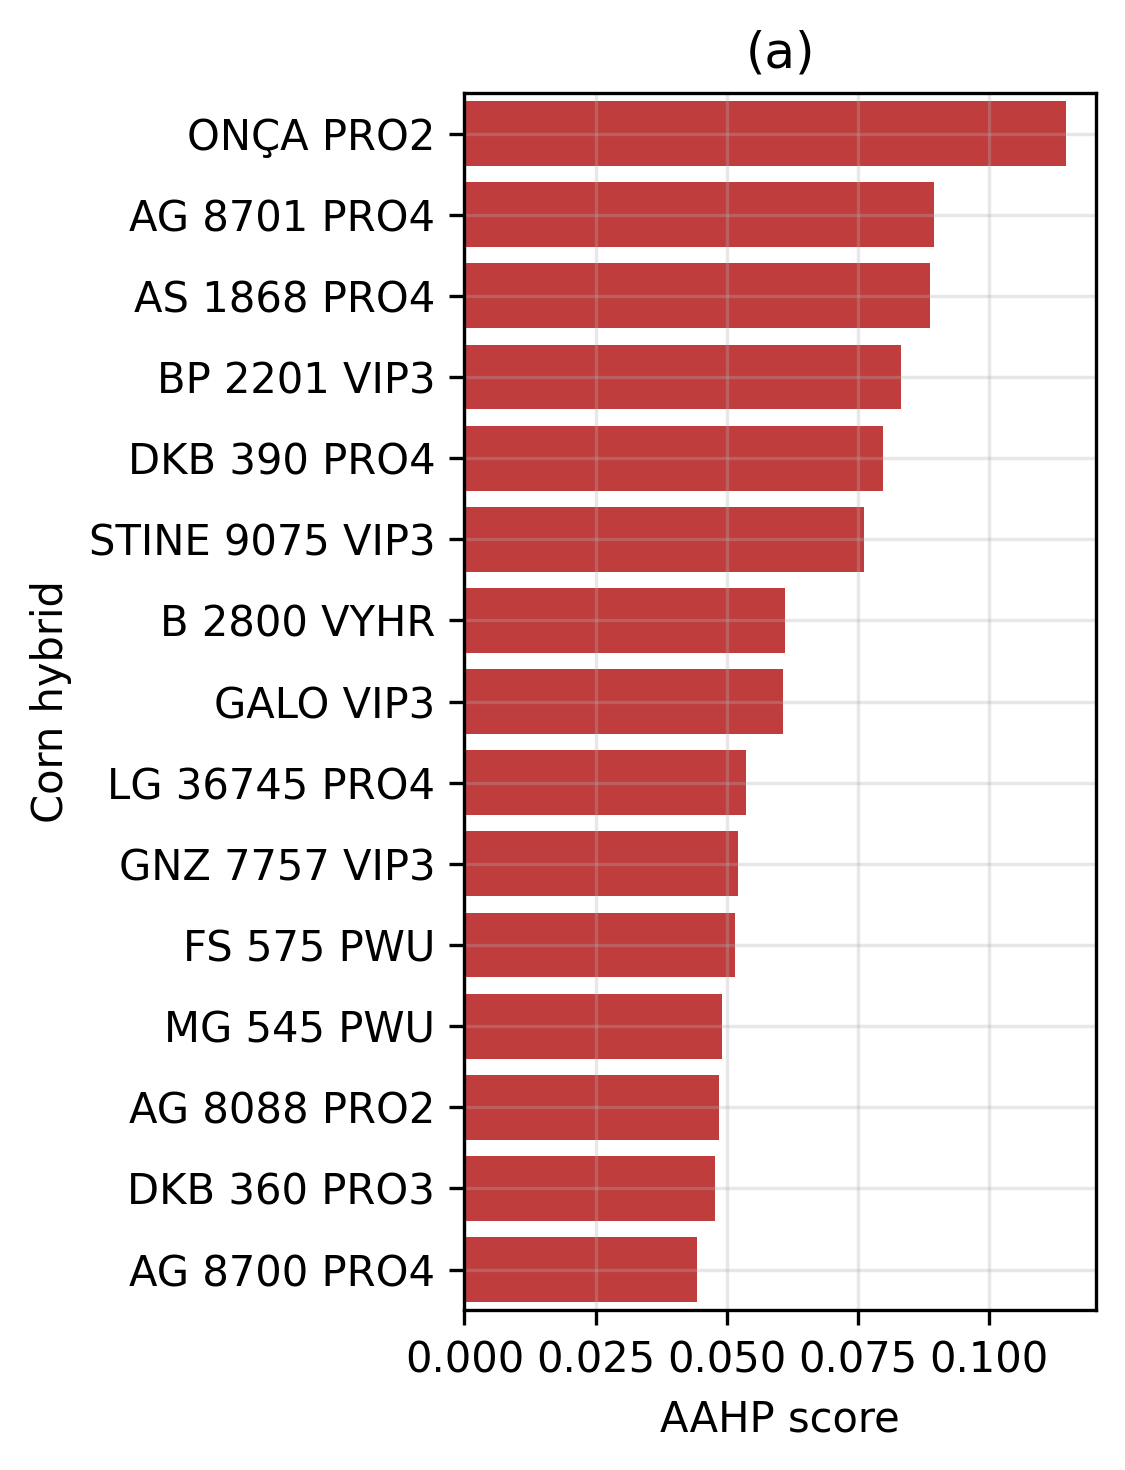

In [31]:
# AHPTD - Automatic approach
ahptd_obj = AHPTD()

# Values of distance in Control/Drought and Control/Salinity and Control/Al toxicity
ControlDrought  = df_distances_transformed['Drought'].to_numpy()
ControlSalinity = df_distances_transformed['Salinity'].to_numpy()
ControlToxicity = df_distances_transformed['Al toxicity'].to_numpy()

# Normalize values usingo "the smaller, the more preferable"
ControlDrought_     = ahptd_obj.SMP(ControlDrought)
ControlSalinity_    = ahptd_obj.SMP(ControlSalinity)
ControlToxicity_    = ahptd_obj.SMP(ControlToxicity)

# Normalized data matrix
V = np.array([ControlDrought_, ControlSalinity_, ControlToxicity_]).T

# Criterion weight
u = ahptd_obj.CriterionWeight(V)

'''
Verify consistency ration (CR)
'''
# Get the PC matrix of criteria
A = ahptd_obj.Conversion(u)
l, u_criteria, cr_criteria = ahptd_obj.LPV(A)
print('CR of Goal: ', cr_criteria)
print('Vector of Criteria: ', u_criteria)

# Get the PC matrix of alternatives
A_ControlDrought_transformed = ahptd_obj.Conversion(ControlDrought_)
A_ControlSalinity_transformed = ahptd_obj.Conversion(ControlSalinity_)
A_ControlToxicity_transformed = ahptd_obj.Conversion(ControlToxicity_)

# Get the local priority vectors
l_ControlDrought, v_ControlDrought, cr_ControlDrought = ahptd_obj.LPV(A_ControlDrought_transformed)
l_ControlSalinity, v_ControlSalinity, cr_ControlSalinity = ahptd_obj.LPV(A_ControlSalinity_transformed)
l_ControlToxicity, v_ControlToxicity, cr_ControlToxicity = ahptd_obj.LPV(A_ControlToxicity_transformed)
print('CR of Criteria - Control/Drought: ', cr_ControlDrought)
print('CR of Criteria - Control/Salinity: ', cr_ControlSalinity)
print('CR of Criteria - Control/Al toxicity: ', cr_ControlToxicity)

# Get the global priority vector
V_global = np.array([v_ControlDrought, v_ControlSalinity, v_ControlToxicity]).T

# GPV
x = ahptd_obj.GPV(u_criteria, V_global)

# Show the better Hybrid
ind = np.argmax(x)
print('\nBetter Hybrid: ', Hybrids[ind], '\n')

# Dataframe for Repetition
# Show final weights of Hybrids
df_x = pd.DataFrame({'Hybrid': Hybrids, 'AAHP': x})
df_x = df_x.sort_values(by=['AAHP'], ascending=False)

plt.figure(figsize=(4, 5), dpi=300)
sns.barplot(x='AAHP', y='Hybrid', data=df_x, orient='h', color='tab:red')
plt.xlabel('AAHP score')
plt.ylabel('Corn hybrid')
plt.title('(a)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

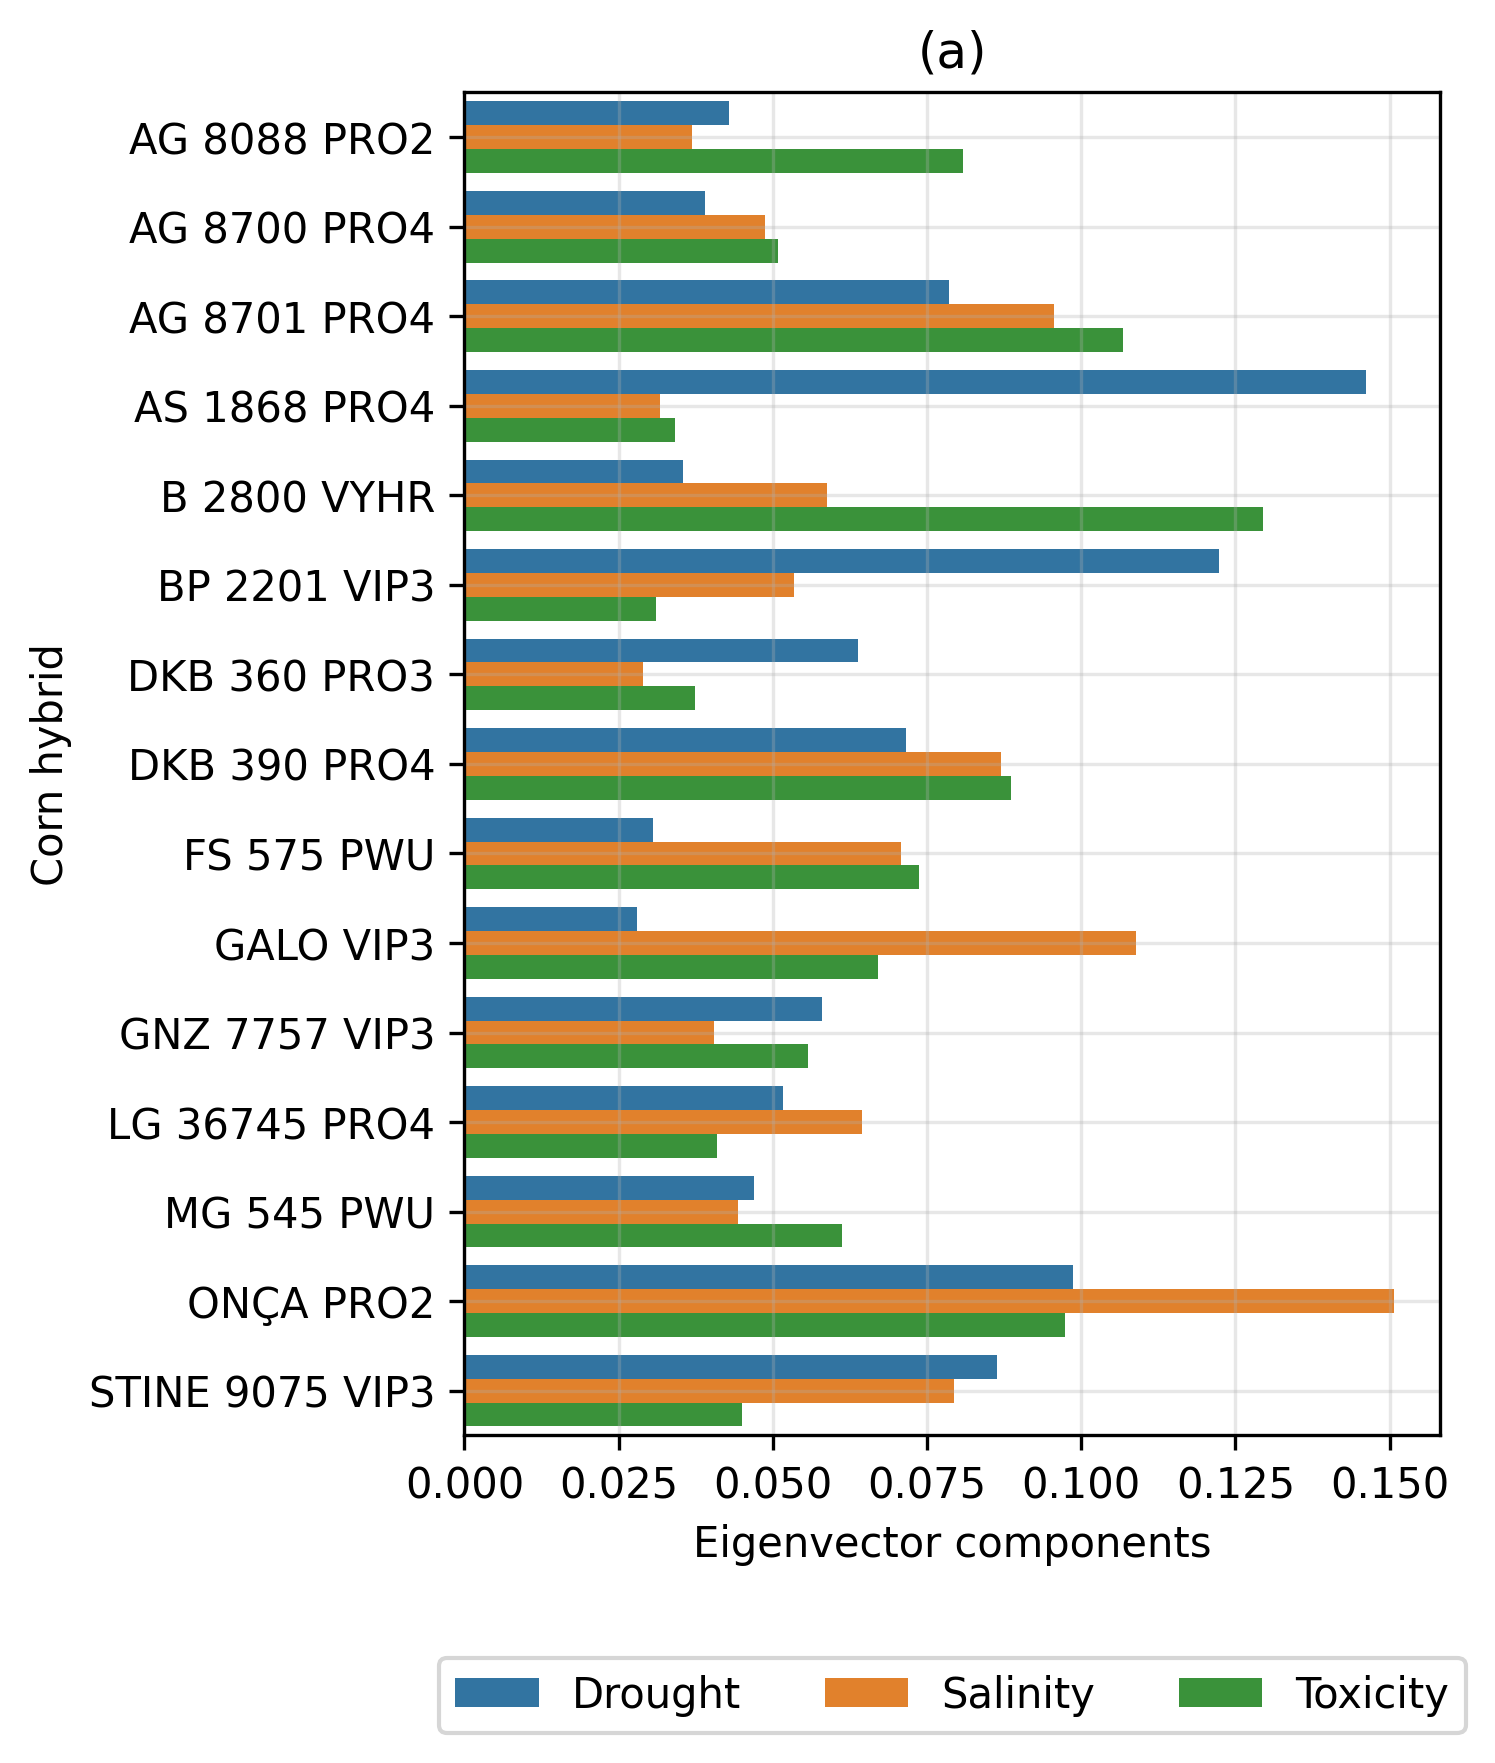

,Hybrid,Drought,Salinity,Toxicity
0,AG 8088 PRO2,0.042824,0.036852,0.080817
1,AG 8700 PRO4,0.038998,0.048741,0.050794
2,AG 8701 PRO4,0.078598,0.095560,0.106787
3,AS 1868 PRO4,0.146203,0.031752,0.034066
4,B 2800 VYHR,0.035514,0.058728,0.129414
5,BP 2201 VIP3,0.122403,0.053502,0.031045
6,DKB 360 PRO3,0.063731,0.028926,0.037382
7,DKB 390 PRO4,0.071577,0.087056,0.088683
8,FS 575 PWU,0.030637,0.070762,0.073649
9,GALO VIP3,0.027900,0.108846,0.067116


In [32]:
#Show eigenvectors

df_vectors_transformed = pd.DataFrame({
    'Hybrid': Hybrids,
    'Drought': v_ControlDrought,
    'Salinity': v_ControlSalinity,
    'Toxicity': v_ControlToxicity
})

plt.figure(figsize=(5, 6), dpi=300)

df_distances_melt = pd.melt(df_vectors_transformed, id_vars=['Hybrid'], value_vars=['Drought', 'Salinity', 'Toxicity'], var_name='Treatment', value_name='Eigenvector')

sns.barplot(y='Hybrid', x='Eigenvector', hue='Treatment', data=df_distances_melt, orient='h', palette='tab10')
plt.ylabel('Corn hybrid')
plt.xlabel('Eigenvector components')
plt.title('(a)')
plt.grid(alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()

plt.show()
df_vectors_transformed

## Various criteria weights

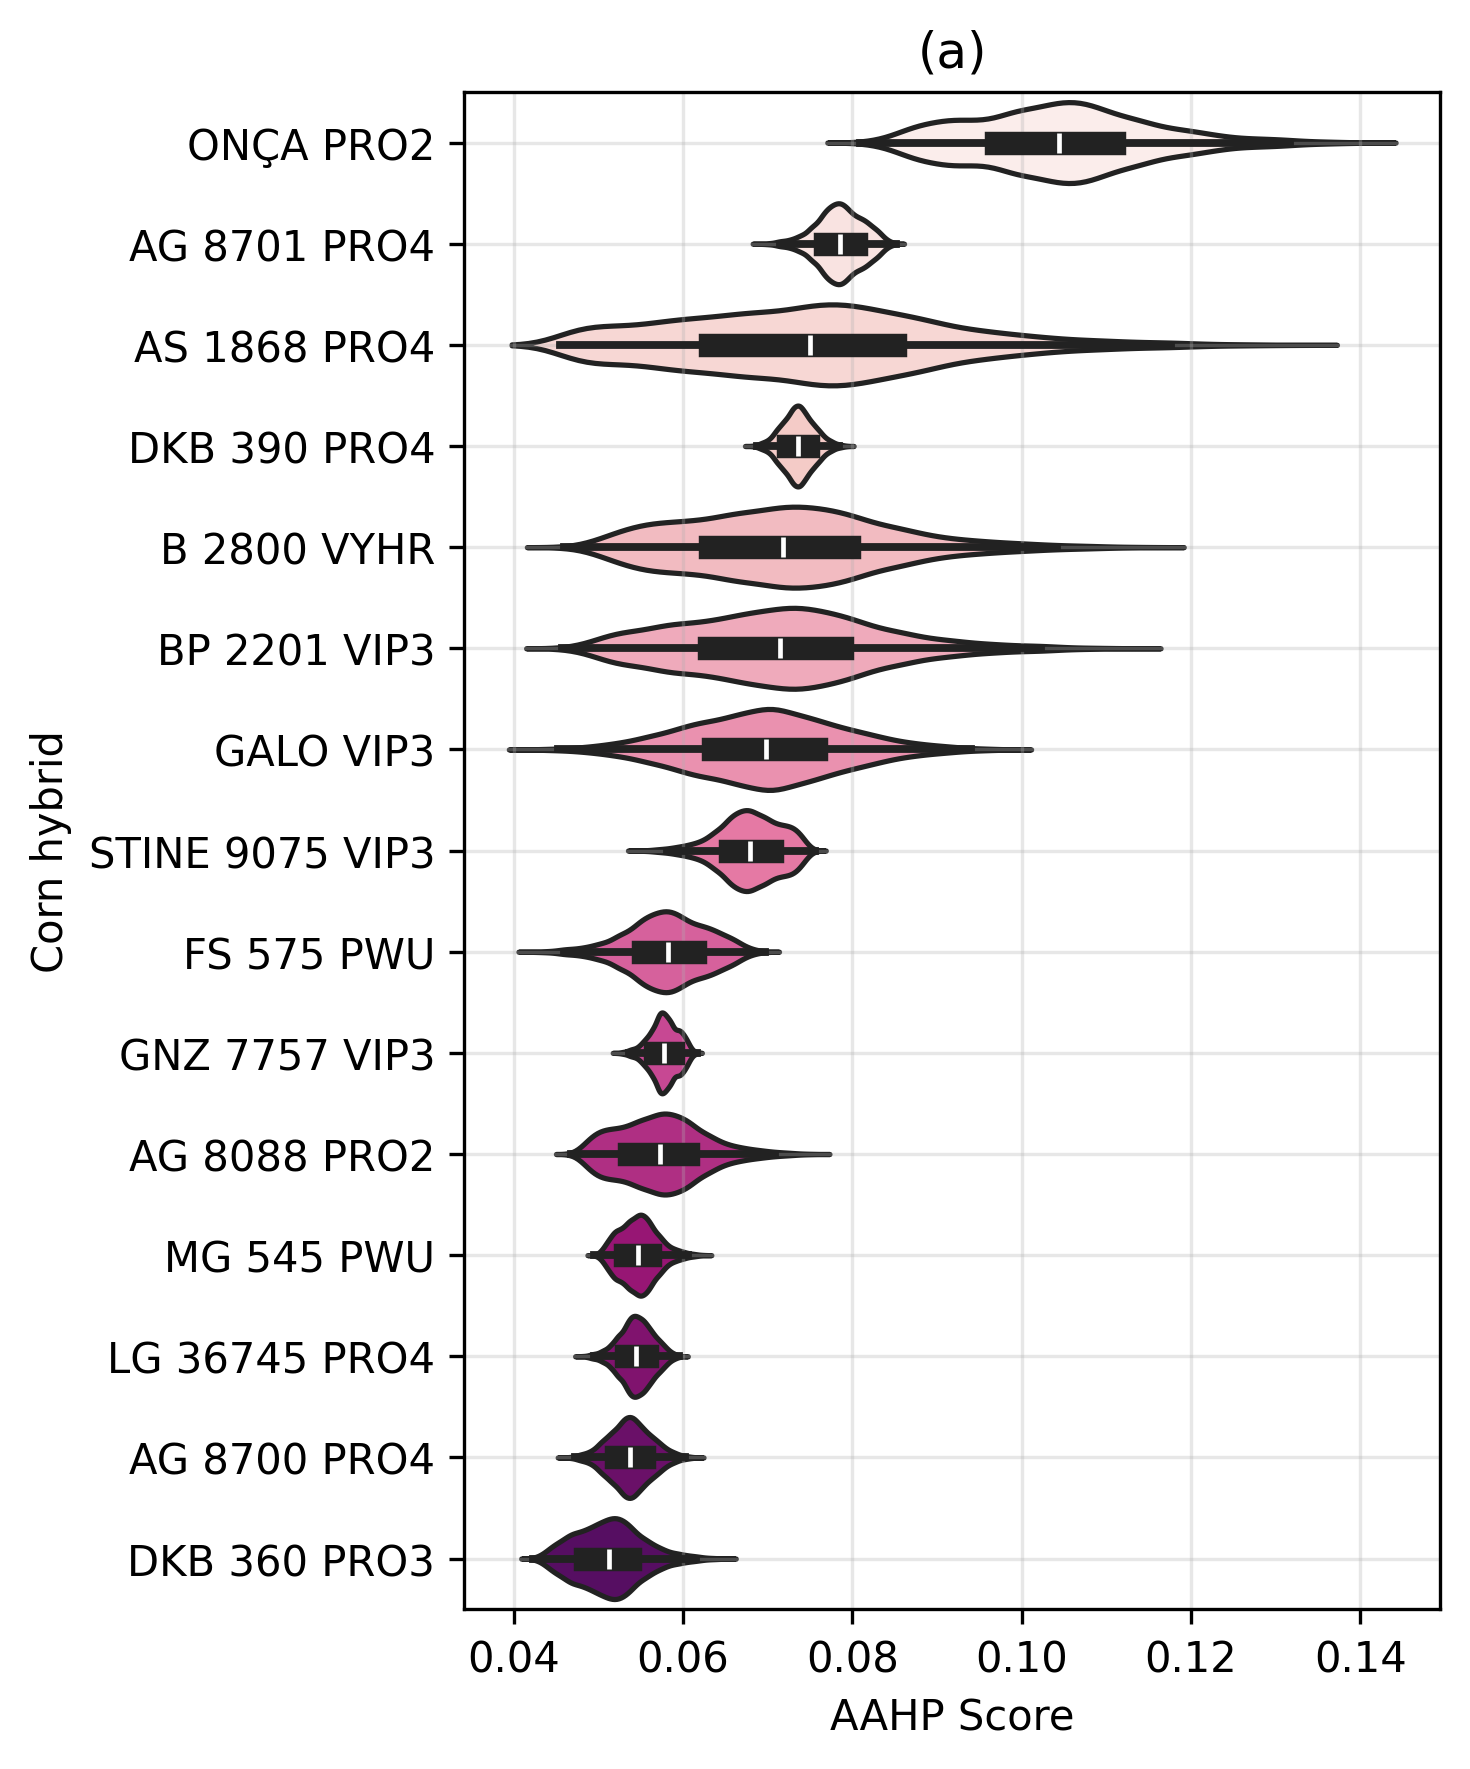

In [33]:
# AHPTD - Automatic approach
ahptd_obj = AHPTD()

# Values of distance in Control/Drought and Control/Salinity and Control/Al toxicity
ControlDrought  = df_distances_transformed['Drought'].to_numpy()
ControlSalinity = df_distances_transformed['Salinity'].to_numpy()
ControlToxicity = df_distances_transformed['Al toxicity'].to_numpy()

# Normalize values usingo "the smaller, the more preferable"
ControlDrought_     = ahptd_obj.SMP(ControlDrought)
ControlSalinity_    = ahptd_obj.SMP(ControlSalinity)
ControlToxicity_    = ahptd_obj.SMP(ControlToxicity)

# Normalized data matrix
V = np.array([ControlDrought_, ControlSalinity_, ControlToxicity_]).T

# Various weights approach
GPVs = []
for k in np.arange(0, 5000):
    u = np.random.rand(3)
    u = u/np.linalg.norm(u, 1)
    x = ahptd_obj.GPV(u, V)
    GPVs.append(x)

# Bulit adataframe and ordering
df_k = pd.DataFrame(data=GPVs, columns=Hybrids)
df_k_sorted = df_k.median().sort_values(ascending=False)
df_k = df_k[df_k_sorted.index]

# Show results
plt.figure(figsize=(5, 6), dpi=300)
sns.violinplot(data=df_k, orient='h', palette="RdPu")
plt.xlabel('AAHP Score')
plt.ylabel('Corn hybrid')
plt.grid(alpha=0.3)
plt.title('(a)')
plt.tight_layout()
plt.show()

# Data original: Hybrid selection using AHPTD for each repetition

## Same criteria weights

CR of Goal:  0.04622549644738945
Vector of Criteria:  [0.49338597 0.31081368 0.19580035]
CR of Criteria - Control/Drought:  0.03193480566283982
CR of Criteria - Control/Salinity:  0.031850719545939356
CR of Criteria - Control/Al toxicity:  0.038356549564741535

Better Hybrid:  ONÇA PRO2 



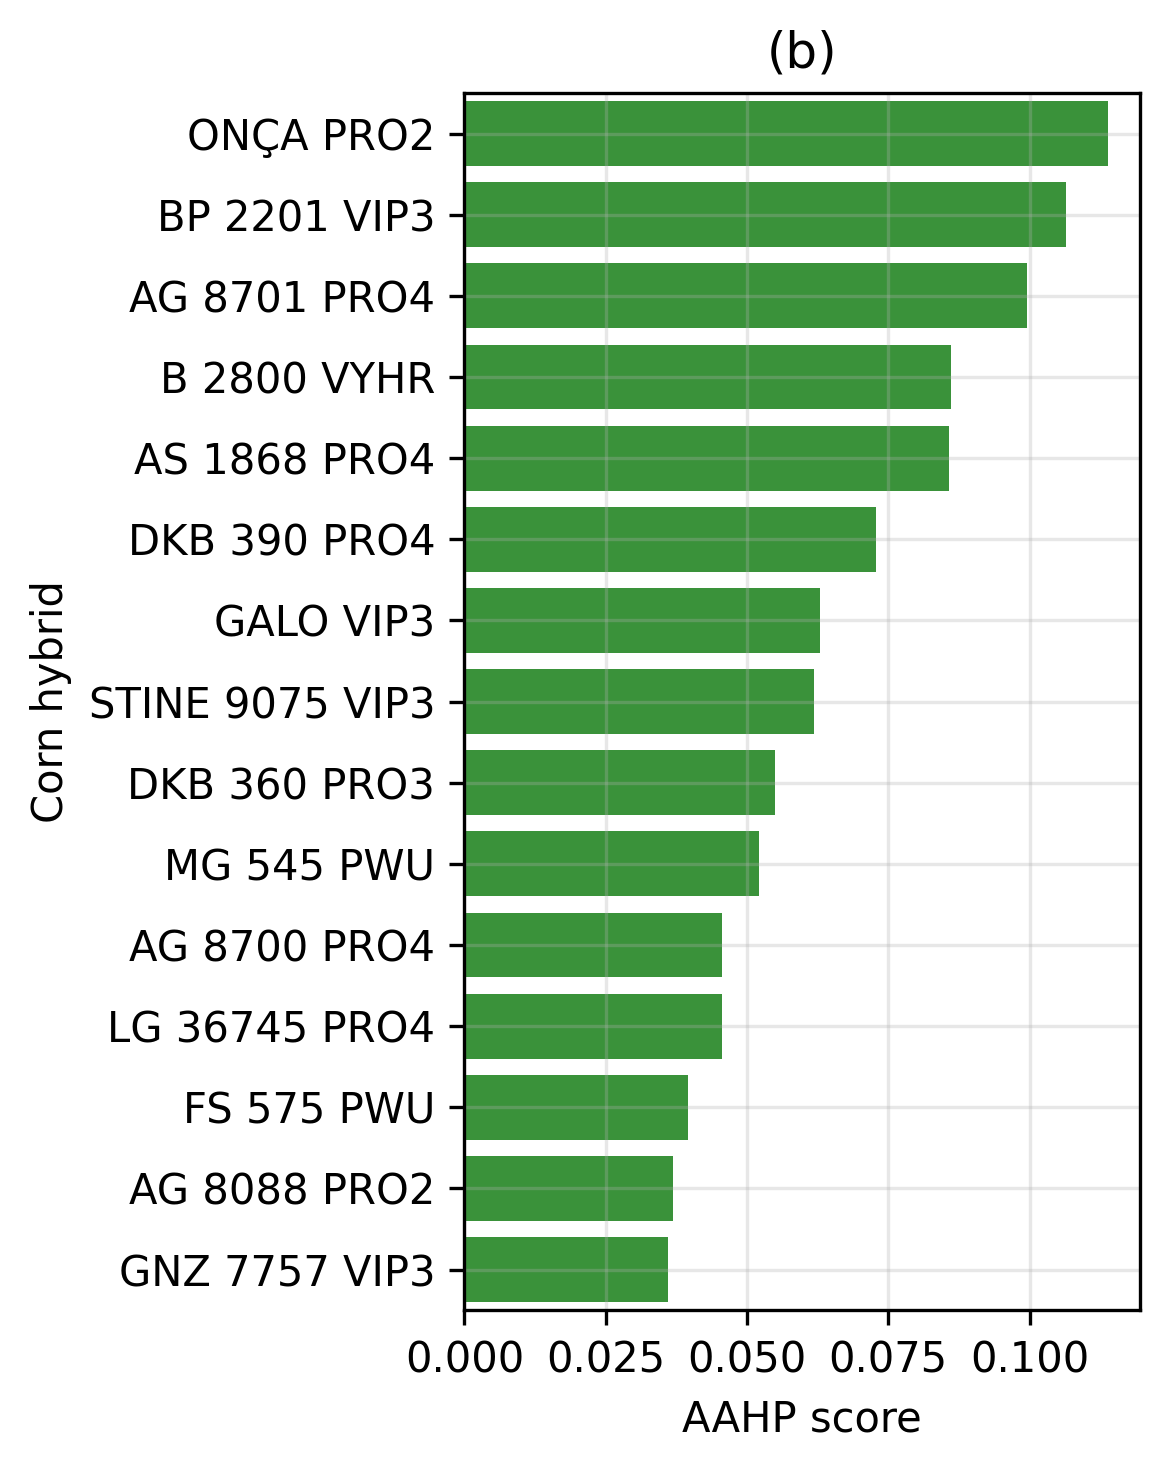

In [34]:
# AHPTD - Automatic approach
ahptd_obj = AHPTD()

# Values of distance in Control/Drought and Control/Salinity and Control/Al toxicity
ControlDrought  = df_distances_original['Drought'].to_numpy()
ControlSalinity = df_distances_original['Salinity'].to_numpy()
ControlToxicity = df_distances_original['Al toxicity'].to_numpy()

# Normalize values usingo "the smaller, the more preferable"
ControlDrought_     = ahptd_obj.SMP(ControlDrought)
ControlSalinity_    = ahptd_obj.SMP(ControlSalinity)
ControlToxicity_    = ahptd_obj.SMP(ControlToxicity)

# Normalized data matrix
V = np.array([ControlDrought_, ControlSalinity_, ControlToxicity_]).T

# Criterion weight
u = ahptd_obj.CriterionWeight(V)

'''
Verify consistency ration (CR)
'''
# Get the PC matrix of criteria
A = ahptd_obj.Conversion(u)
l, u_criteria, cr_criteria = ahptd_obj.LPV(A)
print('CR of Goal: ', cr_criteria)
print('Vector of Criteria: ', u_criteria)

# Get the PC matrix of alternatives
A_ControlDrought = ahptd_obj.Conversion(ControlDrought_)
A_ControlSalinity = ahptd_obj.Conversion(ControlSalinity_)
A_ControlToxicity = ahptd_obj.Conversion(ControlToxicity_)

# Get the local priority vectors
l_ControlDrought, v_ControlDrought, cr_ControlDrought = ahptd_obj.LPV(A_ControlDrought)
l_ControlSalinity, v_ControlSalinity, cr_ControlSalinity = ahptd_obj.LPV(A_ControlSalinity)
l_ControlToxicity, v_ControlToxicity, cr_ControlToxicity = ahptd_obj.LPV(A_ControlToxicity)
print('CR of Criteria - Control/Drought: ', cr_ControlDrought)
print('CR of Criteria - Control/Salinity: ', cr_ControlSalinity)
print('CR of Criteria - Control/Al toxicity: ', cr_ControlToxicity)

# Get the global priority vector
V_global = np.array([v_ControlDrought, v_ControlSalinity, v_ControlToxicity]).T

# GPV
x = ahptd_obj.GPV(u_criteria, V_global)

# Show the better Hybrid
ind = np.argmax(x)
print('\nBetter Hybrid: ', Hybrids[ind], '\n')

# Dataframe for Repetition
# Show final weights of Hybrids
df_x = pd.DataFrame({'Hybrid': Hybrids, 'AAHP': x})
df_x = df_x.sort_values(by=['AAHP'], ascending=False)

plt.figure(figsize=(4, 5), dpi=300)
sns.barplot(x='AAHP', y='Hybrid', data=df_x, orient='h', color='tab:green')
plt.xlabel('AAHP score')
plt.ylabel('Corn hybrid')
plt.title('(b)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

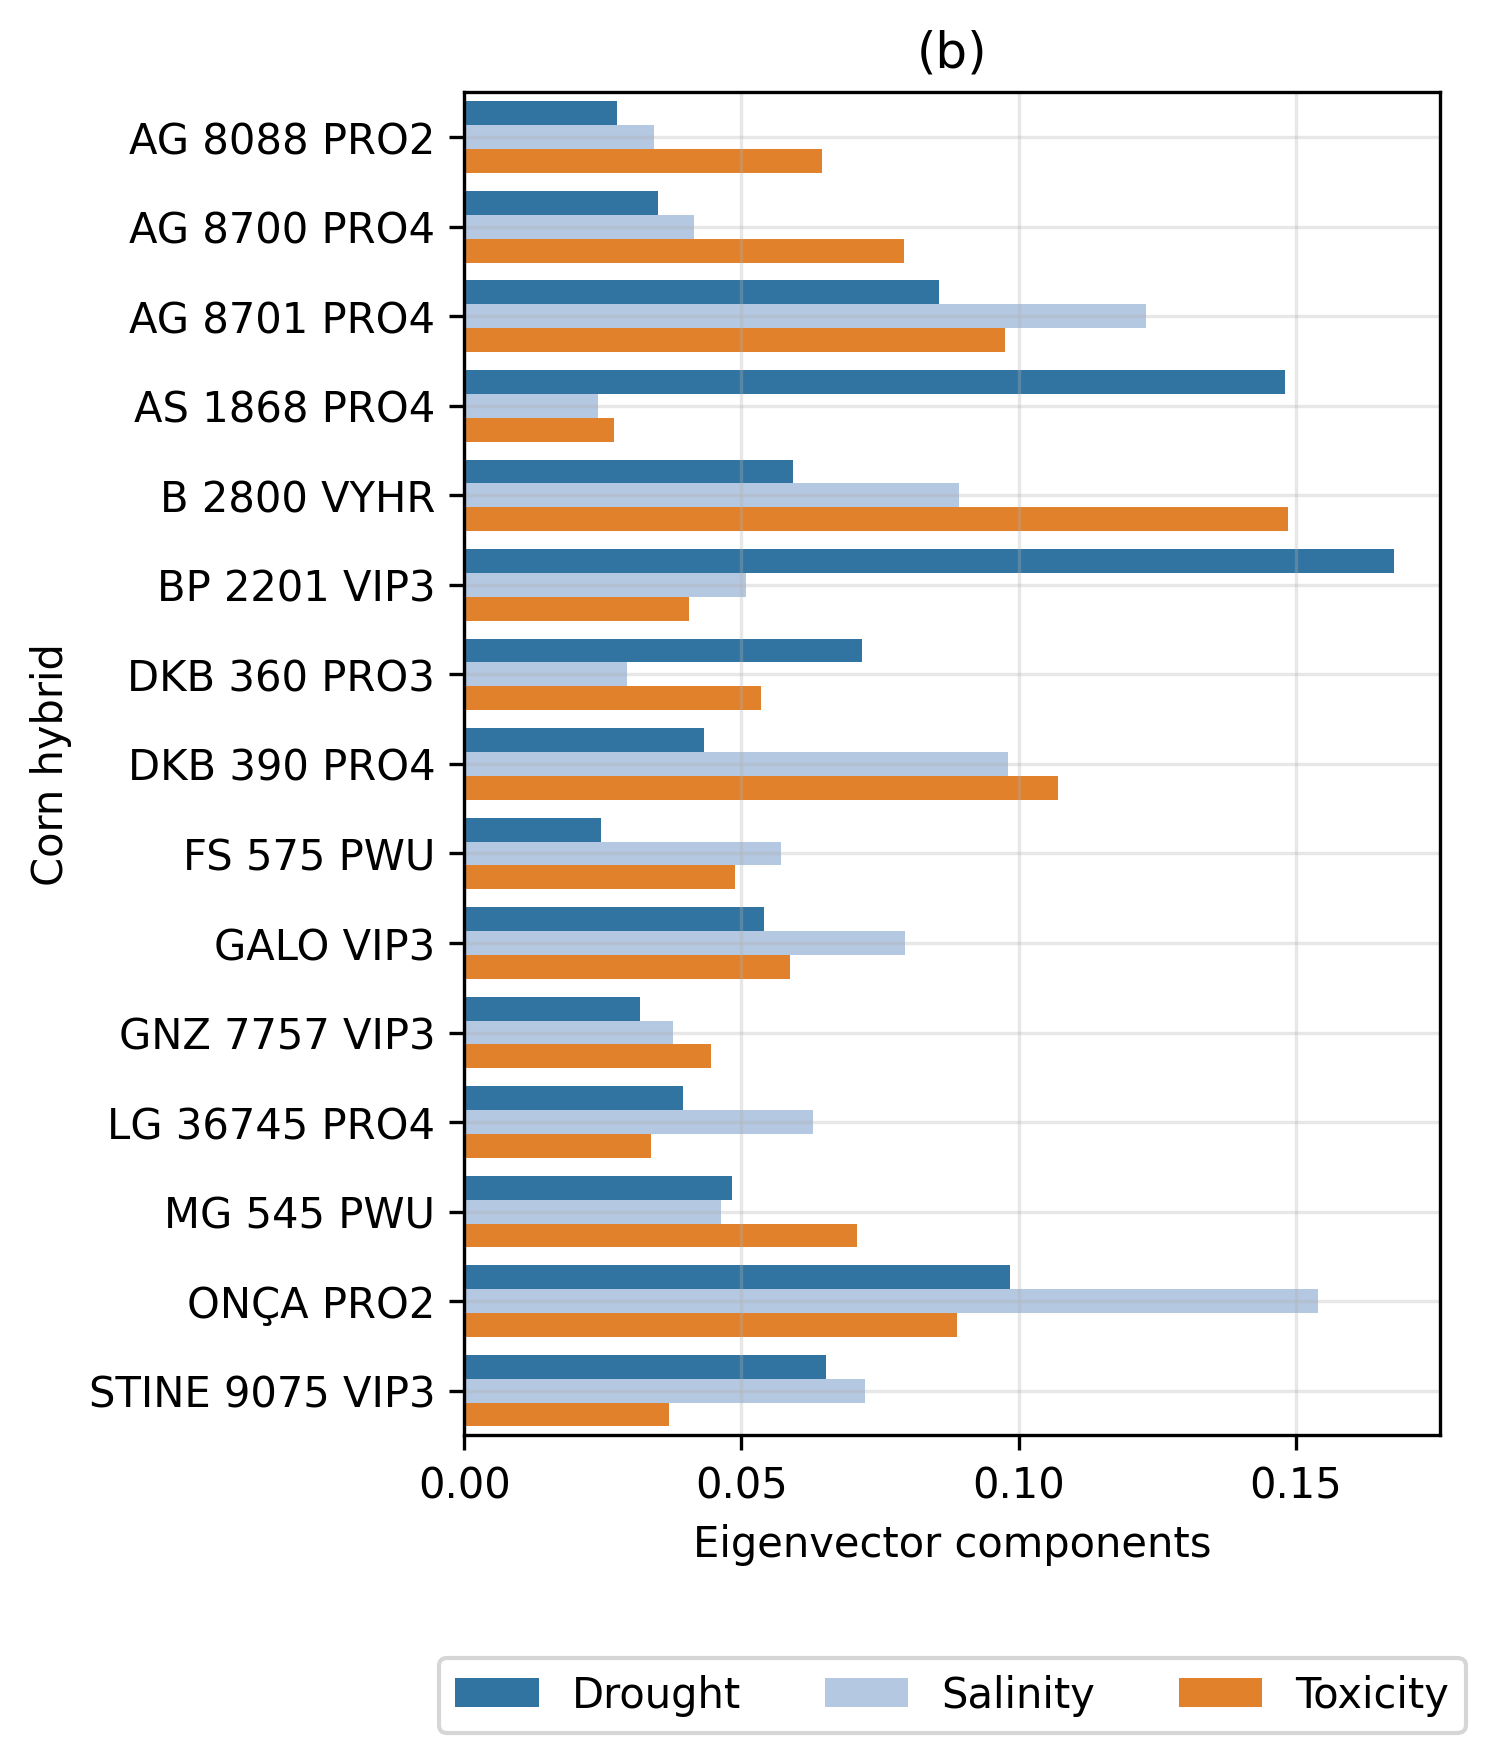

In [35]:
#Show eigenvectors

df_vectors_original = pd.DataFrame({
    'Hybrid': Hybrids,
    'Drought': v_ControlDrought,
    'Salinity': v_ControlSalinity,
    'Toxicity': v_ControlToxicity
})

plt.figure(figsize=(5, 6), dpi=300)

df_distances_melt = pd.melt(df_vectors_original, id_vars=['Hybrid'], value_vars=['Drought', 'Salinity', 'Toxicity'], var_name='Treatment', value_name='Eigenvector')

sns.barplot(y='Hybrid', x='Eigenvector', hue='Treatment', data=df_distances_melt, orient='h', palette='tab20')
plt.ylabel('Corn hybrid')
plt.xlabel('Eigenvector components')
plt.title('(b)')
plt.grid(alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()

plt.show()


## Various criteria weights

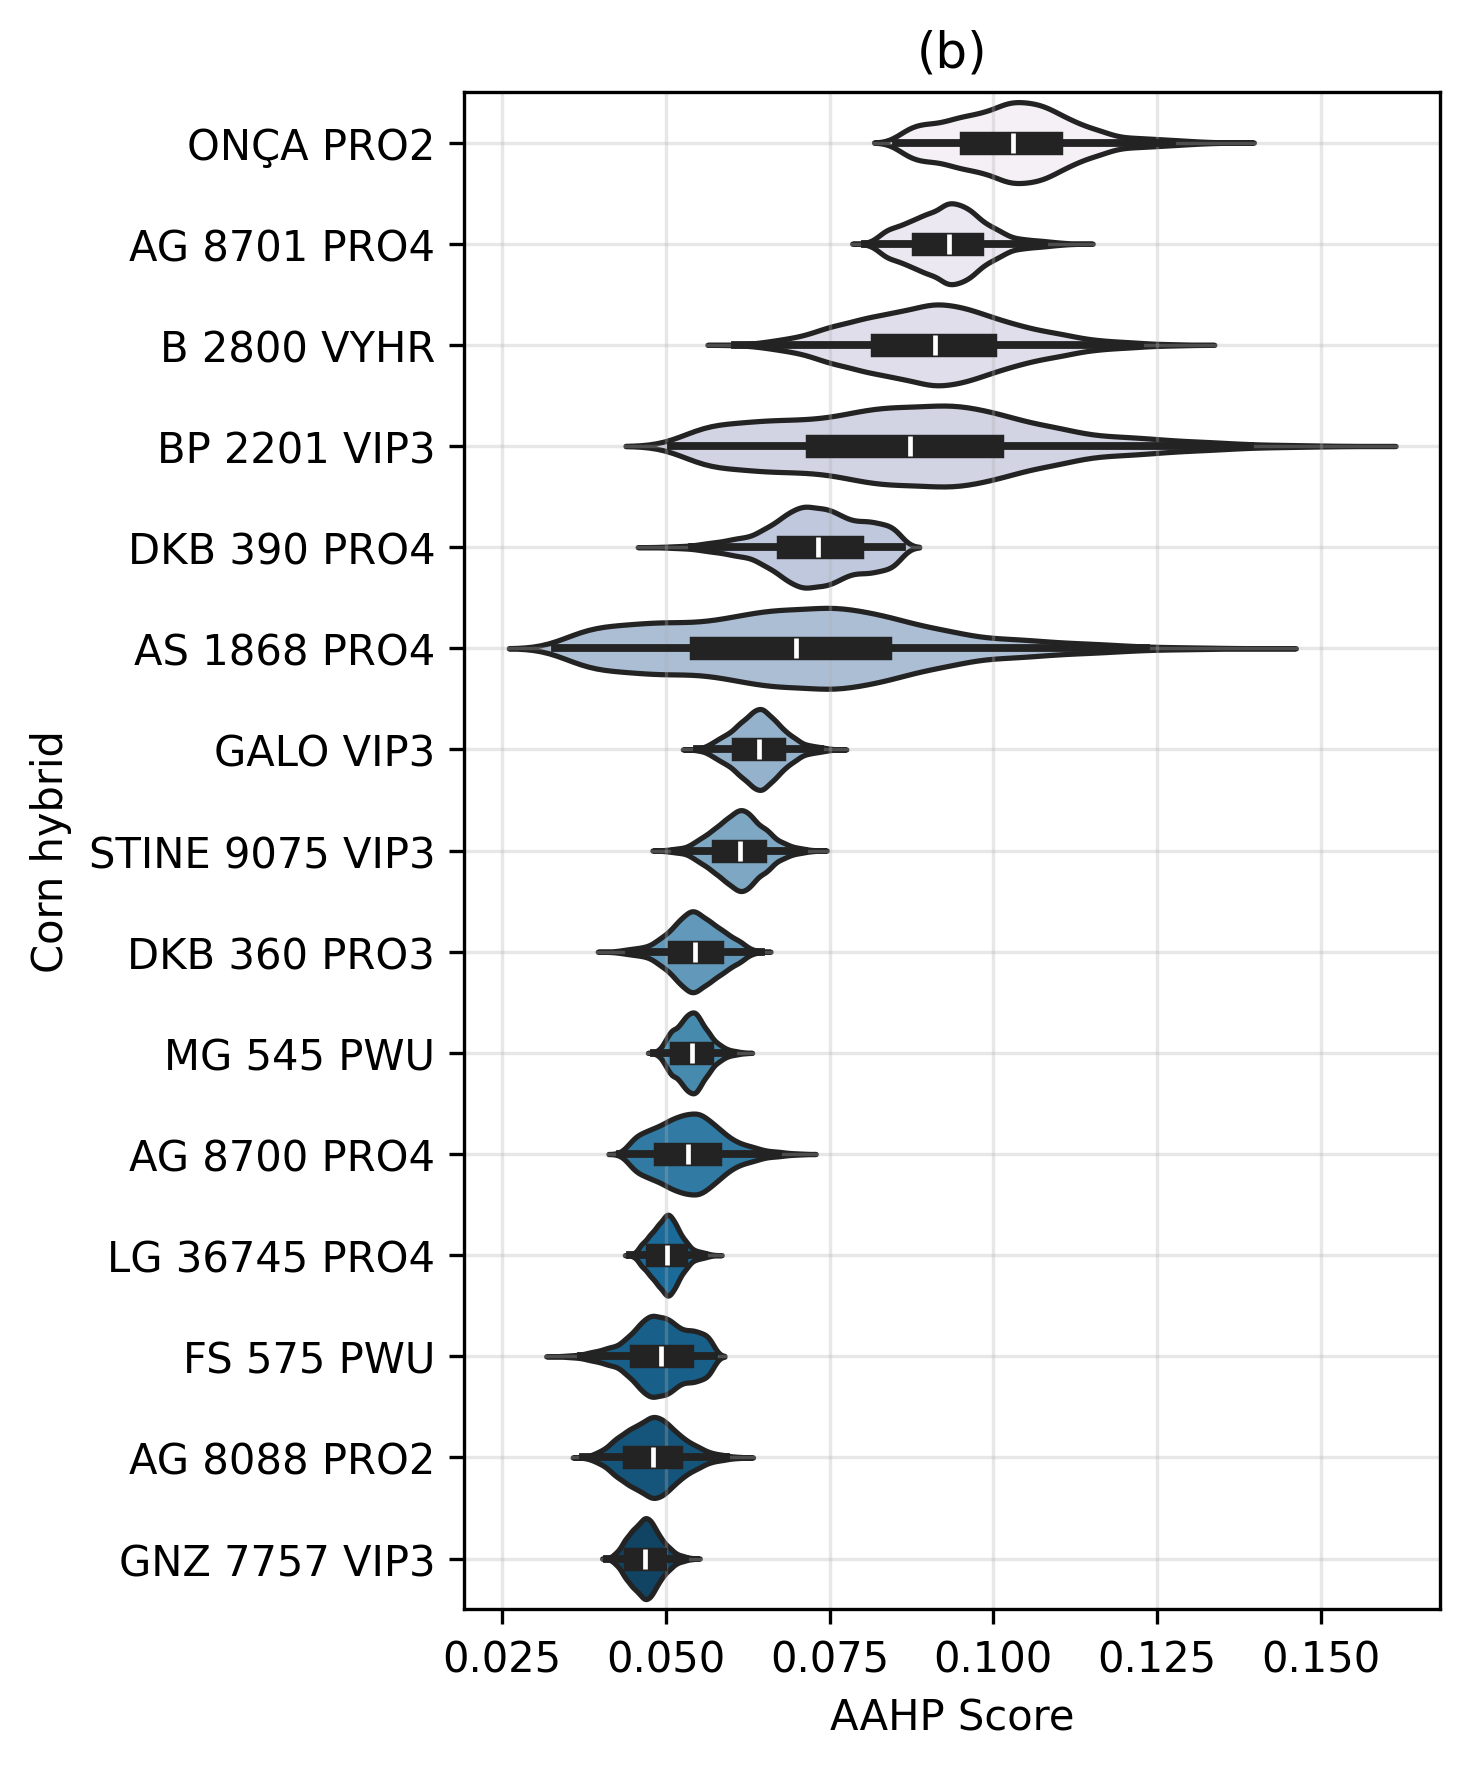

In [36]:
# AHPTD - Automatic approach
ahptd_obj = AHPTD()

# Values of distance in Control/Drought and Control/Salinity and Control/Al toxicity
ControlDrought  = df_distances_original['Drought'].to_numpy()
ControlSalinity = df_distances_original['Salinity'].to_numpy()
ControlToxicity = df_distances_original['Al toxicity'].to_numpy()

# Normalize values usingo "the smaller, the more preferable"
ControlDrought_     = ahptd_obj.SMP(ControlDrought)
ControlSalinity_    = ahptd_obj.SMP(ControlSalinity)
ControlToxicity_    = ahptd_obj.SMP(ControlToxicity)

# Normalized data matrix
V = np.array([ControlDrought_, ControlSalinity_, ControlToxicity_]).T

# Various weights approach
GPVs = []
for k in np.arange(0, 5000):
    u = np.random.rand(3)
    u = u/np.linalg.norm(u, 1)
    x = ahptd_obj.GPV(u, V)
    GPVs.append(x)

# Bulit adataframe and ordering
df_k = pd.DataFrame(data=GPVs, columns=Hybrids)
df_k_sorted = df_k.median().sort_values(ascending=False)
df_k = df_k[df_k_sorted.index]

# Show results
plt.figure(figsize=(5, 6), dpi=300)
sns.violinplot(data=df_k, orient='h', palette="PuBu")
plt.xlabel('AAHP Score')
plt.ylabel('Corn hybrid')
plt.grid(alpha=0.3)
plt.title('(b)')
plt.tight_layout()
plt.show()